In [5]:
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import requests

import PIL
from PIL import Image

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [7]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])
training_dataset = datasets.CIFAR10(root='./data_', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
data_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
def img_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

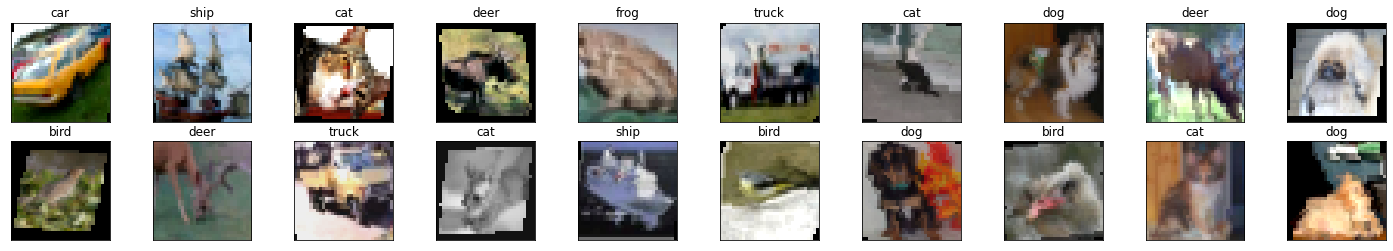

In [15]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(img_convert(images[idx]))
    ax.set_title(data_classes[labels[idx].item()])

In [16]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.fc1 = nn.Linear(4 * 4 * 64, 500)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 64)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [17]:
def calculate_corrects_and_losses(loader, model, loss_function):
    loss = 0.0
    correct = 0.0
    
    running_loss = 0.0
    running_correct = 0.0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            res = loss_function(outputs, labels)
            running_loss += res.item()

            _, pred_labels = torch.max(outputs, 1)
            running_correct += torch.sum(pred_labels == labels.data)
        
    loss = running_loss / len(loader)
    correct = running_correct.float() / len(loader)
        
    return loss, correct

In [18]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
epochs = 15
losses = []
corrects = []

val_losses = []
val_corrects = []

for e in range(epochs):
    running_loss = 0.0
    running_correct = 0.0
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, pred_labels = torch.max(outputs, 1)
        running_correct += torch.sum(pred_labels == labels.data)
        
    epoch_loss = running_loss / len(training_loader)
    losses.append(epoch_loss)
    
    epoch_correct = running_correct.float() / len(training_loader)
    corrects.append(epoch_correct)
    
    print('training loss: {:.4f} corrects: {:.4f}'.format(epoch_loss, epoch_correct))
    
    val_epoch_loss, val_epoch_correct = calculate_corrects_and_losses(validation_loader, model, criterion)
    val_losses.append(val_epoch_loss)
    val_corrects.append(val_epoch_correct)

In [ ]:
plt.plot(losses, label='training losses')
plt.plot(val_losses, label='val losses')
plt.legend()

In [ ]:
plt.plot([x.cpu() for x in corrects], label='training corrects')
plt.plot([x.cpu() for x in val_corrects], label='val corrects')
plt.legend()

In [ ]:
url = "https://www.ixbt.com/img/n1/news/2021/10/5/084ed9e98d6d6c45ac49b1474002d2f0_large_large.jpg"
response = requests.get(url, stream=True)
img = Image.open(response.raw)
img

In [ ]:
img = transform(img)
plt.imshow(img_convert(img))

In [ ]:
img = img.to(device)
img = img.unsqueeze(0)
img.size()

In [ ]:
output = model(img)
_, pred_label = torch.max(output, 1)
data_classes[pred_label]

In [ ]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
fig = plt.figure(figsize=(25, 4))

outputs = model(images)
_, pred_labels = torch.max(outputs, 1)

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(img_convert(images[idx]))
    ax.set_title("{} ({})".format(data_classes[pred_labels[idx]], data_classes[labels[idx]]), color=("green" if pred_labels[idx] == labels[idx] else "red"))